In [2]:
%matplotlib inline
import matplotlib.pyplot as plt      

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam

import hyperparams as hp
from datasets import LJSpeechDataset, collate_fn
from visualize import show_spectrogram
from audio import wav_to_spectrogram
from text import text_to_sequence, sequence_to_text
from models import MelSpectrogramNet

In [3]:
PATH = '/home/austin/data/tacotron/LJSpeech-1.0'

In [4]:
dataset = LJSpeechDataset(path=PATH, text_transforms=text_to_sequence,
                                     audio_transforms=wav_to_spectrogram, cache=True)

  0%|          | 1/13084 [00:00<34:42,  6.28it/s]

Building Cache..


100%|██████████| 13084/13084 [04:49<00:00, 45.12it/s]


In [5]:
text, audio = dataset[0]

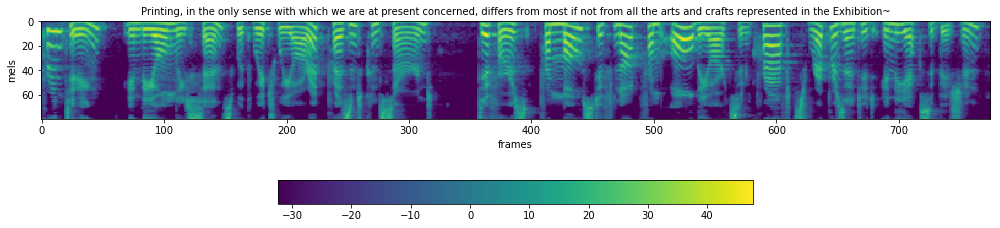

In [6]:
fig = show_spectrogram(audio.T, sequence_to_text(text), True)

In [7]:
from torch.utils.data.dataset import Subset


In [ ]:
dataset = Subset(dataset, range(50))

In [ ]:
Image.open(fig)

In [ ]:
melnet = MelSpectrogramNet()
melnet.cuda()

In [ ]:
def train(model, optimizer, dataset, num_epochs, batch_size=1):
    model.train()
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    for epoch in range(num_epochs):
        total_loss = 0
        for b, (text_batch, audio_batch, text_lengths, audio_lenghts) in enumerate(loader):
            text = Variable(text_batch).cuda()
            targets = Variable(audio_batch, requires_grad=False).cuda()
            
            #  create stop targets
            stop_targets = torch.zeros(targets.size(1), targets.size(0))
            for i in range(len(stop_targets)):
                stop_targets[i, audio_lenghts[i]-1] = 1
            stop_targets = Variable(stop_targets, requires_grad=False).cuda()

            optimizer.zero_grad()
            outputs, stop_tokens, attention = model(text, targets)
            spec_loss = F.mse_loss(outputs, targets)
            stop_loss = F.binary_cross_entropy_with_logits(stop_tokens, stop_targets)
            loss = spec_loss + stop_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.data[0]
            if b % 20 == 0 and b != 0:
                total_loss = total_loss / 100
                print("[%d][loss:%5.2f]" %
                  (b, total_loss))
                total_loss = 0

In [ ]:
optimizer = Adam(melnet.parameters())

In [ ]:
train(melnet, optimizer, dataset, 1)